In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from xgboost import XGBClassifier

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
full_df = pd.concat([train_df, test_df], axis=0)

In [3]:
y = train_df.Survived

In [4]:
full_df['IsAlone'] = (full_df['SibSp'] + full_df['Parch'] == 0) * 1
ages = full_df.groupby(['Sex', 'Pclass', 'IsAlone']).Age.median()
ages

Sex     Pclass  IsAlone
female  1       0          37.0
                1          35.0
        2       0          24.5
                1          30.0
        3       0          20.5
                1          22.0
male    1       0          39.0
                1          42.0
        2       0          29.0
                1          30.0
        3       0          17.0
                1          26.0
Name: Age, dtype: float64

In [5]:
fares = full_df.groupby(['Pclass', 'Embarked']).Fare.median()
fares

Pclass  Embarked
1       C           76.7292
        Q           90.0000
        S           52.0000
2       C           15.3146
        Q           12.3500
        S           15.3750
3       C            7.8958
        Q            7.7500
        S            8.0500
Name: Fare, dtype: float64

In [14]:
def prep(df):
    X = pd.DataFrame((df['Sex'] == 'female') * 1)
    df['IsAlone'] = (df['SibSp'] + df['Parch'] == 0) * 1
    X['IsAlone'] = df['IsAlone']

    ages_default = df.apply(lambda s: ages[s['Sex'], s['Pclass'], s['IsAlone']], axis=1)
    ages_complete = df.Age.fillna(ages_default).astype(int)
    X['Age'] = ages_complete - (ages_complete % 5)  # Round by 5.
    
    df['Embarked'].fillna('S', inplace=True)
    fares_default = df.apply(lambda s: fares[s['Pclass'], s['Embarked']], axis=1)
    fares_complete = df.Fare.fillna(fares_default)
    X['Fare'] = np.log(fares_complete + 1.0)

    dummy1 = pd.get_dummies(df['Pclass'], prefix='Pclass')
    dummy2 = pd.get_dummies(df['Embarked'], prefix='Emb')
    X = pd.concat([X, dummy1, dummy2], axis=1)

    # Drop unnecessary features.
    for col in ['Emb_Q', 'Emb_C', 'Pclass_1']:
        X.drop(col, axis=1, inplace=True)
    return X

X = prep(train_df)
X.head()

Sex  IsAlone  Age      Fare  Pclass_2  Pclass_3  Emb_S
0    0        0   20  2.110213         0         1      1
1    1        0   35  4.280593         0         0      0
2    1        1   25  2.188856         0         1      1
3    1        0   35  3.990834         0         0      1
4    0        1   35  2.202765         0         1      1

In [15]:
m = XGBClassifier()
m.fit(X, y)
for x in reversed(sorted(zip(m.feature_importances_, X.columns.values))):
    print(x)

(0.48963317, 'Fare')
(0.23763955, 'Age')
(0.094098881, 'Pclass_3')
(0.066985644, 'Sex')
(0.051036682, 'Emb_S')
(0.043062203, 'Pclass_2')
(0.01754386, 'IsAlone')


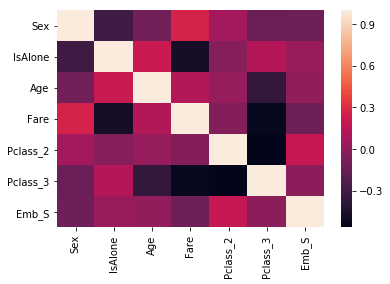

In [16]:
sns.heatmap(X.corr())

In [17]:
help(XGBClassifier.__init__)

Help on function __init__ in module xgboost.sklearn:

__init__(self, max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)
    Initialize self.  See help(type(self)) for accurate signature.



In [18]:
param_grid = {
    'max_depth': [2, 3, 5],
    'learning_rate':[0.05],
    'n_estimators':[100, 200],
    'objective':['binary:logistic'],
#'min_child_weight':[1,2,3],
#    'max_delta_step':[3, 5],
#'gamma':[0,3,10],
#'subsample':[.4, .5, .6, .7, .8],
#'colsample_bytree':[.5, .6, .7, .8],
#'nthread':[4],
#'scale_pos_weight':[1],
#'reg_alpha': [.01, .02, .03, .04],
    'n_jobs': [2],
    'seed': [0],
}

clf = GridSearchCV(XGBClassifier(), param_grid=param_grid, cv=10, scoring='accuracy')
clf.fit(X, y)

print('Best Params: ', clf.best_params_)
print('Best Score: ', clf.best_score_)

Best Params:  {'max_depth': 5, 'seed': 0, 'learning_rate': 0.05, 'n_jobs': 2, 'objective': 'binary:logistic', 'n_estimators': 100}
Best Score:  0.840628507295


# Accuracy Scores (CV=10)
- sex only: 0.786756453423
- sex + pclass: 0.775533108866
- sex + pclass + isalone: 0.791245791246
- sex + pclass + isalone + embark: 0.808080808081 (submit: 0.77990)
- sex + pclass + isalone + embark + age: 0.81593714927
- sex + pclass + isalone + embark + age + fare: 0.840628507295 (submit: 0.78468)

In [11]:
tX = prep(test_df)
tY = clf.predict(tX)

In [12]:
ans = pd.DataFrame(test_df.PassengerId)
ans['Survived'] = tY
ans

PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         1
5            897         0
6            898         0
7            899         0
8            900         1
9            901         0
10           902         0
11           903         0
12           904         1
13           905         0
14           906         1
15           907         1
16           908         0
17           909         0
18           910         0
19           911         0
20           912         0
21           913         1
22           914         1
23           915         0
24           916         1
25           917         0
26           918         1
27           919         0
28           920         0
29           921         0
..           ...       ...
388         1280         0
389         1281         0
390         1282         0
391         1283         1
392         1284         0
393         1285         0
394         1286         0
395         1287         1
396         1288         0
397         1289         1
398         1290         0
399         1291         0
400         1292         1
401         1293         0
402         1294         1
403         1295         0
404         1296         0
405         1297         0
406         1298         0
407         1299         0
408         1300         1
409         1301         1
410         1302         1
411         1303         1
412         1304         0
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]

In [13]:
ans.to_csv('out-xgb3.csv', index=False)